In [1]:
import os
import sys

from matplotlib import dates as mdates
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('..')
import util_wsa_uncertainty

sns.set()

In [2]:
os.chdir('..')

In [3]:
df_dataset = pd.read_csv('data/processed/processed_daysahead3_R000.csv', index_col=0)
df_dataset.index = pd.to_datetime(df_dataset.index)
df_dataset.head()

,sigma,Vp_pred,Vp_obs,crps
2010-01-08 18:00:00,73.711060,320.569697,283.535000,24.496866
2010-01-09 00:00:00,70.522470,312.584848,289.951667,19.353964
2010-01-09 06:00:00,73.384475,304.600000,294.783333,17.672686
2010-01-09 12:00:00,71.817747,318.100000,291.255000,20.740659
2010-01-09 18:00:00,78.413401,305.400000,278.983333,21.842004


In [4]:
knn_dataset = util_wsa_uncertainty.KnnUncertaintyDataset(input_map='AGONG', sat='ACE', real=0, daysahead=3)

In [5]:
#ts = pd.Timestamp('2010-05-17 00:00:00')
ts = pd.Timestamp('2012-12-20 00:00:00')
idx = df_dataset.index.searchsorted(ts)
idx

4305

In [6]:
NPRED = knn_dataset.npred
NOBS = knn_dataset.nobs

In [7]:
times = df_dataset.iloc[idx : idx + NPRED].index
Vp_obs = df_dataset.Vp_obs.iloc[idx : idx + NOBS]
Vp_pred = df_dataset.Vp_pred.iloc[idx : idx + NPRED]
nbrs =  knn_dataset.lookup_neighbors(times, Vp_obs, Vp_pred, k=100000)

In [8]:
distances =  np.array([n.distance for n in nbrs])
weights =1/distances
weights /= weights.max()
nbr_num = np.arange(len(nbrs))

{'ref': <Axes: label='ref'>, 'weights': <Axes: label='weights'>, 'nbr0': <Axes: label='nbr0'>, 'nbr1': <Axes: label='nbr1'>}


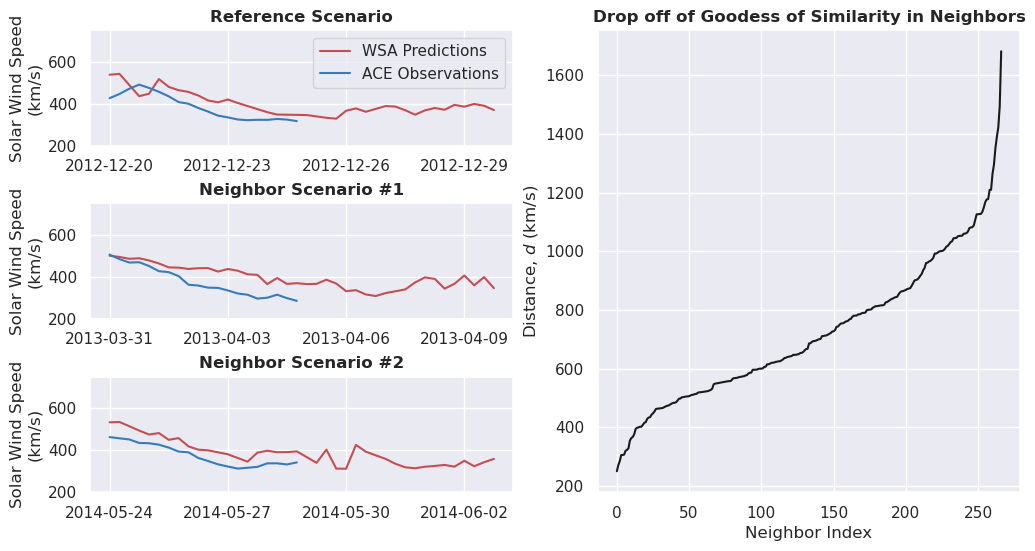

In [9]:
blue_color = '#367cb9'
red_color = 'r'
black_color= 'k'
pred_label = 'WSA Predictions'
obs_label = 'ACE Observations'
speed_ylabel = 'Solar Wind Speed\n(km/s)'
datetime_form = mdates.DateFormatter("%Y-%m-%d")

fig, axes = plt.subplot_mosaic([['ref', 'weights'], ['nbr0', 'weights'], ['nbr1', 'weights']], figsize=(12, 6))
print(axes)

ax = axes['ref']
ax.plot(times, Vp_pred, color=red_color, label=pred_label)
ax.plot(times[:NOBS], Vp_obs, color=blue_color, label=obs_label)
ax.set_ylabel(speed_ylabel)
ax.set_title('Reference Scenario', fontweight='bold')
ax.legend(loc='upper right')

for i in range(2):
    ax = axes[f'nbr{i}']

    cur_times = np.concatenate((nbrs[i].before_times, nbrs[i].after_times))
    cur_Vp_pred = np.concatenate((nbrs[i].before_pred, nbrs[i].after_pred))
    
    ax.plot(cur_times, cur_Vp_pred, color=red_color, label=pred_label)
    ax.plot(nbrs[i].before_times, nbrs[i].before_obs, color=blue_color, label=obs_label)
    ax.set_ylabel(speed_ylabel)
    ax.set_title(f'Neighbor Scenario #{i+1}', fontweight='bold')

for ax_code in ['ref', 'nbr0', 'nbr1']:
    ax = axes[ax_code]
    ax.set_yticks([200, 400, 600])
    ax.set_ylim(200, 750)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))

ax = axes['weights']
ax.plot(nbr_num, distances, color=black_color)
ax.set_ylabel('Distance, $d$ (km/s)')
ax.set_xlabel('Neighbor Index')
#ax.set_ylim(0, 1)
ax.set_title('Drop off of Goodess of Similarity in Neighbors', fontweight='bold')

plt.subplots_adjust(wspace=0.2, hspace=.5) 
fig.savefig('plots/neighbors_example.png', dpi=300)